# Mean field variance dynamics for noisy signal propagation

In [1]:
# imports
import os, sys, pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

# custom import
from src.numpy_simulation import *
# from src.simulation import *
from src.viz import get_colours
from src.utils import load_experiment
from src.theory import depth
from src.theory import critical_point

# plot settings
import matplotlib as mpl
# mpl.rcParams['figure.figsize'] = [14.0, 6.0]
mpl.rcParams['font.size'] = 100

sns.set_context("paper", font_scale=2)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'
# plt.rcParams.update({'font.size': 50})

# results directory
relative_results_dir = "results"
results_dir = os.path.join(relative_results_dir)

## --- Variance map: Theory vs simulation ---

In [ ]:
experiments = [
    {"dist": "bern", "noise": ('prob_1', 0.6), "act":"relu", "init":"underflow"}, 
    {"dist": "bern", "noise": ('prob_1', 0.6), "act":"relu", "init":"overflow"}, 
    {"dist": "bern", "noise": ('prob_1', 0.6), "act":"relu", "init":"crit"},
    {"dist": "mult gauss", "noise": ('std', 0.25), "act":"relu", "init":"underflow"},
    {"dist": "mult gauss", "noise": ('std', 0.25), "act":"relu", "init":"overflow"}, 
    {"dist": "mult gauss", "noise": ('std', 0.25), "act":"relu", "init":"crit"}
]

for i, experiment in enumerate(experiments):
    dist = experiment['dist']
    noise = experiment['noise']
    act = experiment['act']
    init = experiment['init']
    
    # run simulations for scenario
    noisy_signal_prop_simulations(dist, noise, act, init, seed=i)

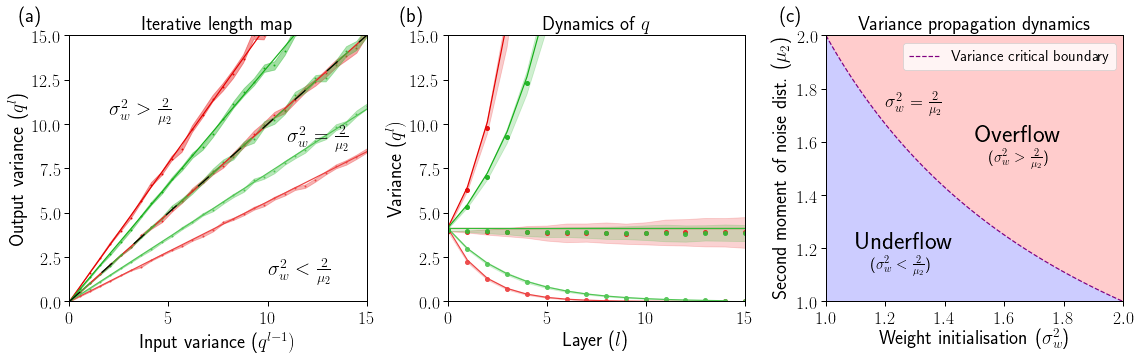

In [15]:
# Dictionary for data that needs to be extracted
tests = [
    {
        "distributions": [{"dist": "mult gauss", "std": 0.25}],
        "activations": ["relu"],
        "inits": ["underflow"]
    },
    {
        "distributions": [{"dist": "mult gauss", "std": 0.25}],
        "activations": ["relu"],
        "inits": ["overflow"]
    },
    {
        "distributions": [{"dist": "mult gauss", "std": 0.25}],
        "activations": ["relu"],
        "inits": ["crit"]
    }
    ,
    {
        "distributions": [{"dist": "bern", "prob_1": 0.6}],
        "activations": ["relu"],
        "inits": ["underflow"]
    },
    {
        "distributions": [{"dist": "bern", "prob_1": 0.6}],
        "activations": ["relu"],
        "inits": ["overflow"]
    },
    {
        "distributions": [{"dist": "bern", "prob_1": 0.6}],
        "activations": ["relu"],
        "inits": ["crit"]
    }
]

############################################################################
############################################################################
# q - length / variance plots
############################################################################
############################################################################
nq = 30
qmax = 15
qrange = np.linspace(0, qmax, nq)
widxs = [0]
bidxs = [0]
n_hidden_layers = 16

n_tests = len(tests)
pal = get_colours(10, 7)
test_data = []
for i, test in enumerate(tests):
    test_data.append(load_experiment(test, ["q_maps", "single_layer_qmap_sim", "multi_layer_qmap_sim"], "results"))


# fig = plt.figure(figsize=(16, 5))

# gs = plt.GridSpec(1, 3)
# ax1 = plt.subplot(gs[0, 0])
# ax2 = plt.subplot(gs[0, 1])
# ax3 = plt.subplot(gs[0, 2])

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 5))

# Add unity line
ax1.plot((0, qmax), (0, qmax), '--', color='k', zorder=900, dashes=(12, 24))
ax1.set_xlim(0, qmax)
ax1.set_ylim(0, qmax)
ax1.set_xlabel('Input variance ($q^{l-1})$')
ax1.set_ylabel('Output variance ($q^l$)')
ax1.set_title("Iterative length map")
ax1.text(2, 10, r'$\sigma^2_w > \frac{2}{\mu_2}$', fontsize=20)
ax1.text(10, 1, r'$\sigma^2_w < \frac{2}{\mu_2}$', fontsize=20)
ax1.text(11, 8.5, r'$\sigma^2_w = \frac{2}{\mu_2}$', fontsize=20)

# axis 2
ax2.set_xlim(0, qmax) #n_hidden_layers-1)
ax2.set_ylim(0, qmax)
ax2.set_xlabel('Layer ($l$)')
ax2.set_ylabel('Variance ($q^{l})$')
ax2.set_title("Dynamics of $q$")

nn = len(test_data)
col_i = 0
for test, attr in zip(test_data, tests):
    for dist in attr["distributions"]:
        if dist['dist'] == "none":
            col_i = 0
        elif dist['dist'] == "bern":
            col_i = 1
        elif "gauss" in dist['dist']:
            col_i = 3

        for act in attr["activations"]:
            for init in attr["inits"]:
                dashes = (None, None)
                if "under" in init:
                    shade_i = 4
                elif "crit" in init:
                    shade_i = 5
                    dashes = (24, 12) if dist['dist'] == "bern" else (None, None)
                else:
                    shade_i = 6

                # extract test data
                qmaps = test[dist['dist']][act][init]['q_maps']['qmaps']
                single_layer_sims = test[dist['dist']][act][init]['single_layer_qmap_sim']
                multi_layer_sims = test[dist['dist']][act][init]['multi_layer_qmap_sim']
                label = ""

                ############################################################################
                # left
                ############################################################################
                for w, b in zip(widxs, bidxs):

                    # plot means of simulation (as dots)
                    mu = single_layer_sims[w, b].mean(-1).mean(-2)
                    ax1.plot(qrange, mu, w, b, marker='o', ls='none', markersize=1, alpha=0.9, zorder=0, c=pal[col_i][shade_i])

                    # add confidence interval around simulation
                    std = single_layer_sims[w, b].mean(-1).std(-2)
                    ax1.fill_between(qrange, mu-std, mu+std, alpha=0.4, label='_nolegend_', color=pal[col_i][shade_i])

                    # theory line
                    ax1.plot(qrange, qmaps[0, 0, :, 1], c=pal[col_i][shade_i], label=label, dashes=dashes)
                    # fixed point
                    

                ############################################################################
                # right
                ############################################################################
                q = 1
                xx = np.arange(multi_layer_sims.shape[-2])
                for w, b in zip(widxs, bidxs):
                    # confidence intervals
                    mu = multi_layer_sims[w, b].mean(axis=-1).mean(axis=0)
                    std = multi_layer_sims[w, b].mean(axis=-1).std(axis=0)

                    # plot theory
                    
                    #################################################
                    # FIX THIS SO THAT IT JUST SIMULATES AND SAVES THE EXACT ONE
                    # find q theory values that start at the given length
                    index = np.argmin(np.abs(qmaps[w, b, :, 0] - 4))
                    #################################################
                    ax2.plot(qmaps[w, b, index, :n_hidden_layers].T, c=pal[col_i][shade_i], label="Theory")

                    # plot the simulation
                    ax2.fill_between(xx, mu-std, mu+std, alpha=0.2, label='_nolegend_', color=pal[col_i][shade_i])

                    # dots for mean
                    ax2.plot(xx, mu, 'o', markersize=4, alpha=0.9, color=pal[col_i][shade_i], label="Simulation")

mu21 = np.linspace(1, 2, 100)
sigma1 = 2/mu21

ax3.plot(mu21, sigma1, c="purple", label="Variance critical boundary", linestyle='--')
ax3.fill_between(mu21, 1, sigma1, facecolor='blue', alpha=0.2)
ax3.fill_between(mu21, 2, sigma1, facecolor='red', alpha=0.2)
ax3.text(1.5, 1.6, 'Overflow', fontsize=25)
ax3.text(1.55, 1.5, r'($\sigma^2_w > \frac{2}{\mu_2}$)', fontsize=15)
ax3.text(1.1, 1.2, 'Underflow', fontsize=25)
ax3.text(1.15, 1.1, r'($\sigma^2_w < \frac{2}{\mu_2}$)', fontsize=15)
ax3.text(1.2, 1.7, r'$\sigma^2_w = \frac{2}{\mu_2}$', fontsize=18)
ax3.set_xlim(1, 2)
ax3.set_ylim(1, 2)
ax3.set_xlabel('Weight initialisation ($\sigma^2_w$)')
ax3.set_ylabel('Second moment of noise dist. ($\mu_2$)')
ax3.legend(prop={'size': 15})
ax3.set_title('Variance propagation dynamics')

fig.text(0.02, 0.95, "(a)", fontsize=20)
fig.text(0.35, 0.95, "(b)", fontsize=20)
fig.text(0.68, 0.95, "(c)", fontsize=20)

plt.gcf().tight_layout()
# plt.show()
plt.savefig("vairance.pdf")